# Extension du Mini Projet Introduction au Deep Learning (Perceptron)
# Alexis Araujo

## Première Partie

In [136]:
from PIL import Image
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
#!pip install h5py
#from utilities import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import h5py
import glob
# import cv2

## Importation du dataSet

In [137]:
dataset_train = "../datasets/train_set.hdf5"
dataset_test = "../datasets/test_set.hdf5"

#on load le dataset d'entrainement
dataset = h5py.File(dataset_train, "r")

x_train = np.array(dataset["X"][:])
y_train = np.array(dataset["y"][:])

#on load le dataset de test
dataset = h5py.File(dataset_test, "r")

x_test = np.array(dataset["X"][:])
y_test = np.array(dataset["y"][:])

In [138]:
#x_train, x_test, y_train, y_test  = load_data_train()

In [139]:
# Afficher les dimensions des données d'entrainement et des étiquettes
print(x_train.shape)
y_train = y_train.reshape(y_train.shape[0], 1)
print(y_train.shape)
# Utilisation de np.unique avec return_counts=True pour obtenir les valeurs uniques et leurs occurrences dans y_train
print(np.unique(y_train, return_counts=True))
#print(y_train == 0, y_train == 1)

(2840, 64, 64)
(2840, 1)
(array([0, 1]), array([1420, 1420], dtype=int64))


In [140]:
# Affiche les dimensions des données de test et des étiquettes
print(x_test.shape)
y_test = y_test.reshape(y_test.shape[0], 1)
print(y_test.shape)
# Utilisation de np.unique avec return_counts=True pour obtenir les valeurs uniques et leurs occurrences dans y_test
print(np.unique(y_test, return_counts=True))
#print(y_test == 0, y_test == 1)

(708, 64, 64)
(708, 1)
(array([0, 1]), array([354, 354], dtype=int64))


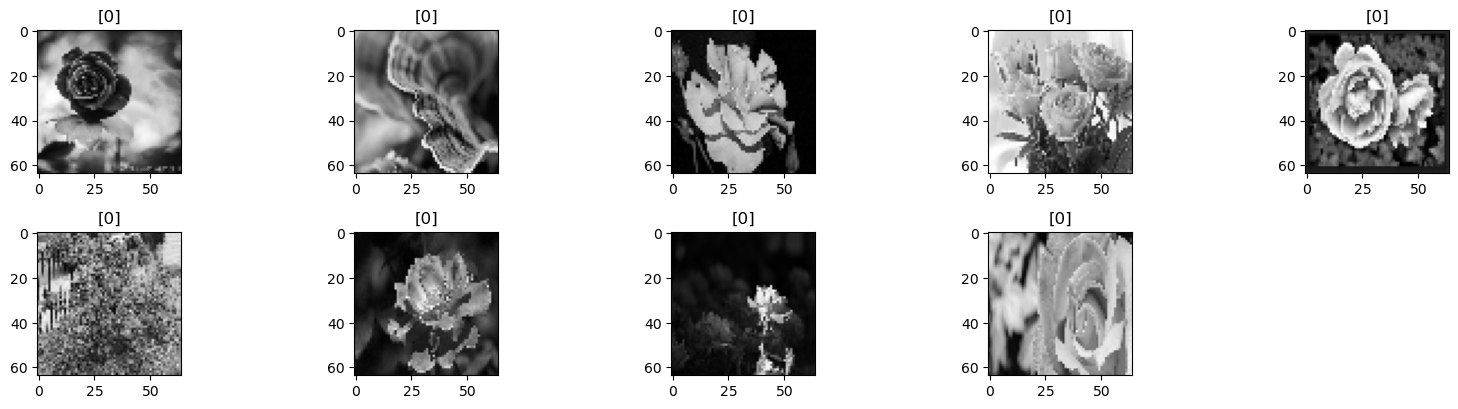

In [141]:
# Création d'une figure
plt.figure(figsize=(16, 8))

# Une boucle sur les 9 premières images et leurs étiquettes pour les afficher
for i in range(1, 10):
    plt.subplot(4, 5, i)  # sous graphique
    plt.imshow(x_train[i], cmap='gray')  # Affiche l'image (x_train[i])
    plt.title(y_train[i])  # Ajoute le titre du sous graphique en affichant les étiquettes
    plt.tight_layout()  # Ajustement
plt.show()

In [142]:
y_train = y_train.T
y_test = y_test.T

In [143]:
# Réorganise les données d'entrainement x_train pour qu'elles soient de forme (nombre d'échantillons, -1)
# et divise toutes les valeurs par la valeur maximale de x_train pour normaliser les données.
x_train = x_train.T
x_train_reshape = x_train.reshape(-1, x_train.shape[-1]) / x_train.max()

In [144]:
# Calcule la valeur maximale dans les données d'entrainement x_train_reshape après la transformation et la normalisation.
x_train_reshape.max()

1.0

In [145]:
# Réorganise les données d'entrainement x_test pour qu'elles soient de forme (nombre d'échantillons, -1)
# et divise toutes les valeurs par la valeur maximale de x_train pour normaliser les données.
x_test = x_test.T
x_test_reshape = x_test.reshape(-1, x_test.shape[-1]) / x_train.max()

In [146]:
# Calcule la valeur maximale dans les données d'entrainement x_test_reshape après la transformation et la normalisation.
x_test_reshape.max()

1.0

In [147]:
m_train = 300
m_test = 80
x_test_reshape = x_test_reshape[:, :m_test]
x_train_reshape = x_train_reshape[:, :m_train]
y_train = y_train[:, :m_train]
y_test = y_test[:, :m_test]

In [148]:
# Affiche la dimension des données d'entraînement x_train_reshape après la transformation et la normalisation.
print(x_train_reshape.shape)
# Affiche la dimension des données d'entraînement x_test_reshape après la transformation et la normalisation.
print(x_test_reshape.shape)

(4096, 300)
(4096, 80)


In [149]:
print(y_train.shape)
print(y_test.shape)

(1, 300)
(1, 80)


In [150]:
# Initialisation des paramètres du modèle
def initialisation(n0, n1, n2):
    W1 = np.random.randn(n1, n0)
    b1 = np.random.randn(n1, 1)
    W2 = np.random.randn(n2, n1)
    b2 = np.random.randn(n2, 1)

    parametres = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return parametres

In [151]:
#Calcule la sortie d'un modèle basé sur une combinaison linéaire des caractéristiques d'entrée X avec des poids W et un biais b, suivi de l'application de la fonction sigmoïde.
def forward_propagation(X, parametres):
    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    Z1 = W1.dot(X) + b1
    A1 = 1 / (1 + np.exp(-Z1))
    Z2 = W2.dot(A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))

    activations = {
        'A1': A1,
        'A2': A2
    }

    return activations

In [152]:
# Régression logisitique
# Calcul du coût (la perte)
def logLoss(A, y):  # Ai est la probabilité prédite par le modèle pour i
    epsilon = 1e-15
    return 1 / len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

In [153]:
# Gradients
# Calcul les gradients de la perte par rapport aux paramètres ( poids et vecteur)
def back_propagation(X, y, activations, parametres):
    A1 = activations['A1']
    A2 = activations['A2']
    W2 = parametres['W2']

    m = y.shape[1]

    dZ2 = A2 - y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }

    return gradients

In [154]:
# Mettre à jour les paramètres (poids et vecteur) en utilisant les gradients utilisés
def update(gradients, parametres, learning_rate):
    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parametres = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    #print(A)
    return parametres

In [155]:
# Faire les prédictions à l'aide d'un modèle Rlogi
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    #print(activations)

    A2 = activations['A2']
    #print(A2)

    return A2 >= 0.5

In [156]:
# Entraîne un modèle de régression logistique (neurone artificiel) en utilisant la descente de gradient stochastique.
def neural_network(x_train, y_train, x_test, y_test, n1 = 32, learning_rate=0.01, n_iter=8000):
    #initialisation W, b
    n0 = x_train.shape[0]
    n2 = x_train.shape[0]
    parametres = initialisation(n0, n1, n2)

    train_cout = []
    train_accuracy = []
    test_cout = []
    test_accuracy = []
    cout = []
    accuracy = []

    for i in tqdm(range(n_iter)):

        #mise à jour
        activations = forward_propagation(x_train, parametres)
        gradients = back_propagation(x_train, y_train, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)

        if i % 10 == 0:
            #train cout/accuracy
            train_cout.append(logLoss(y_train, activations['A2']))
            #precision
            y_pred = predict(x_train, parametres)

            current_accuracy = accuracy_score(y_train.flatten(), y_pred.flatten())
            train_accuracy.append(current_accuracy)

            #test cout/accuracy
            A_test = forward_propagation(x_test, parametres)
            test_cout.append(logLoss(y_test, A_test))
            #precision
            y_pred = predict(x_test, parametres)
            current_accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
            test_accuracy.append(current_accuracy)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_cout, label='train_cout')
    #plt.plot(test_cout, label='test_cout')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(test_accuracy, label='test_accuracy')
    plt.legend()
    plt.show()
    return parametres

In [157]:
# Appel de la fonction et affichage des courbes de coût et d'exactitude pour l'entraînement et le test
parametres1 = neural_network(x_train_reshape, y_train, x_test_reshape, y_test)

  0%|          | 0/8000 [00:00<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [300, 1228800]

Voir si l'image est une tulipe ou une rose

In [ ]:
def predict_single_image(image_path, parametres, image_size=(64, 64)):
    img = Image.open(image_path)
    img = img.convert('L')  # Convertir en niveaux de gris si ce n'est pas déjà fait
    img = img.resize(image_size)
    img_array = np.array(img).reshape(1, -1) / 255.0

    prediction = forward_propagation(img_array, parametres)

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    if prediction >= 0.5:
        print("Rose", prediction)
    else:
        print("Tulipe", prediction)


# Utilisation de la fonction pour prédire une image
image_path_to_predict = '../donnees_basique/rose3.jpg'
predict_single_image(image_path_to_predict, parametres1)

In [ ]:
#Création de la matrice de confusion

from sklearn.metrics import confusion_matrix
import itertools

y_pred = predict(x_test_reshape, parametres1)
cm = confusion_matrix(y_test, y_pred)
cm_plot_labels = ['rose', 'tulipe']


def plot_confusion_matrix(cm, classes, normalize=False, title='Matrice de confusion', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print("Matrice de confusion non normalisée")

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Réalité')
    plt.xlabel('Prédiction')


plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Matrice de confusion sur données de test')

#Création du rapport de classification

from sklearn.metrics import classification_report

target_names = ['roses', 'tulipes']
print(classification_report(y_test, y_pred, target_names=target_names))